# Naive Linear Shallow Water

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Equations

Taking the equation from [wikipedia](https://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form).

**Non-Conservative Form**

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ 
\frac{\partial}{\partial x}\left((H+h)u\right) +
\frac{\partial}{\partial y}\left((H+h)v\right)= 0 \\
\frac{\partial u}{\partial t} &+ u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} - fv =
-g\frac{\partial h}{\partial x} -ku + \nu \left( \frac{\partial^2 u}{\partial x^2} + 
\frac{\partial^2 u}{\partial y^2} \right)\\
\frac{\partial v}{\partial t} &+ u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + fu =
-g\frac{\partial h}{\partial y} -kv + 
\nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)\\
\end{aligned}
$$ (eq:sw)


| Symbol | Variable | Unit | 
|:---------:|:------|:----:|
| $u$ | Zonal Velocity |  $m/s^2$ |
| $v$ | Meridial Velocity |   $m/s^2$ |
| $H$ |Mean Height |   $m$ |
| $h$ |Height Deviation |$m$ |
|$b$ | Topographical height 


**Velocities**. The $u,v$ represent the zonal and meridional velocities in the x,y directions respectively.

**Heights** ($H,h,b$). 
The $H$ represents the mean hight of the horizontal pressure surface. 
The $h$ represents the height deviation of the horizontal pressure surface from its mean height.
$b$ represents the topographical height from a reference $D$.

$$
\begin{aligned}
\eta(x,y,t) &= H(x,y) + h(x,y,t) \\
H(x,y) &= D + b(x,y)
\end{aligned}
$$

**Constants** ($f,k,\nu$). $g$ is the acceleration due to gravity, $k$ is the viscous drag coefficient, and $\nu$ is the kinematic viscosity.

**Linear Version**

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+  H\left(\frac{\partial u}{\partial x} +
\frac{\partial v}{\partial y}\right)= 0 \\
\frac{\partial u}{\partial t} &- fv = -g\frac{\partial h}{\partial x} -ku \\
\frac{\partial v}{\partial t} &+ fu = -g\frac{\partial h}{\partial y} -kv\\
\end{aligned}
$$

**Advection Term**

$$
\begin{aligned}
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} \\
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y}
\end{aligned}
$$


**Diffusion Term**

$$
\begin{aligned}
\nu \left( \frac{\partial^2 u}{\partial x^2} + 
\frac{\partial^2 u}{\partial y^2} \right) \\
\nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{aligned}
$$

## Equations

$$

$$

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_y\psi \\
q &= \nabla^2 \psi - \frac{1}{L_R^2}\psi \\
\psi &= \frac{f}{g} \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y
\end{aligned}
$$

where:
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at latitude $\theta_0$
* $\beta=\frac{1}{R}2\Omega\cos\theta_0 y$ is the $\beta$-plane approximation
* $L_R$ is the Rossby wave coefficient
* $\Omega$ is the angular frequency of rotation

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

In [100]:
def plot_quiver(state, params, t=0, max_quivers=2, plot_range=0.5):
    eta = state.u - params.depth

    n_x, n_y = params.domain.size
    XY = params.domain.grid
    x, y = params.domain.coords

    quiver_stride = (
        slice(1, -1, n_x // max_quivers),
        slice(1, -1, n_y // max_quivers),
    )

    fig, ax = plt.subplots(figsize=(8, 6))

    # print(x.shape, y.shape, eta.shape)

    if np.any((state.u[quiver_stride] != 0) | (state.v[quiver_stride] != 0)):
        ax.quiver(
            x[quiver_stride[0]] / 1e3,
            y[quiver_stride[1]] / 1e3,
            state.u[quiver_stride],
            state.v[quiver_stride],
            clip_on=True,
        )

    pts = ax.pcolormesh(
        XY[1:-1, 1:-1, 0] / 1e3,
        XY[1:-1, 1:-1, 1] / 1e3,
        eta[1:-1, 1:-1],
        vmin=-plot_range,
        vmax=-plot_range,
        cmap="RdBu_r",
    )
    plt.colorbar(pts, label=r"$\eta$ [m]")

    ax.set(
        # aspect="equal",
        xlabel=r"$x$ [km]",
        ylabel=r"$y$ [km]",
        title=f"T={t/86_400:5.2f} days",
    )

    plt.tight_layout()
    plt.show()

## Domain

In [101]:
n_x = 100
dx = 20e3

n_y = 101
dy = 20e3

print(f"Nx: {n_x*dx:_.0f} [m]")
print(f"dx: {dx:_.0f} [m]")

print(f"Ny: {n_y*dy:_.0f} [m]")
print(f"dy: {dy:_.0f} [m]")

Nx: 2_000_000 [m]
dx: 20_000 [m]
Ny: 2_020_000 [m]
dy: 20_000 [m]


In [102]:
domain = Domain(xmin=(0, 0), xmax=(n_x * dx, n_y * dy), dx=(dx, dy))
domain.ndim, domain.size

(2, (100, 101))

### Parameters


In [103]:
import typing as tp


class StateParams(tp.NamedTuple):
    gravity: float
    depth: float
    coriolis_param: float
    domain: Domain

    @property
    def phase_speed(self):
        return jnp.sqrt(self.gravity * self.depth)

    @property
    def rossby_radius(self):
        return jnp.sqrt(self.gravity * self.depth) / self.coriolis_param

    @property
    def dt(self):
        return (
            0.5
            * min(self.domain.dx[0], self.domain.dx[1])
            / jnp.sqrt(self.gravity * self.depth)
        )

In [104]:
state_params = StateParams(gravity=9.81, depth=100, coriolis_param=2e-4, domain=domain)

print(f"Phase Speed: {state_params.phase_speed:,.2f} m/s")
print(f"Rossby Radius: {state_params.rossby_radius:,.2f} [m]")
print(f"dt: {state_params.dt:,.2f} [s]")

Phase Speed: 31.32 m/s
Rossby Radius: 156,604.60 [m]
dt: 319.28 [s]


## Initial Conditions

In [105]:
def init_h(params: StateParams) -> Array:
    depth, rossby_radius = params.depth, params.rossby_radius

    XY = params.domain.grid
    X, Y = XY[..., 0], XY[..., 1]
    x, y = params.domain.coords
    n_x, n_y = params.domain.size

    h = params.depth + 1.0 * jnp.exp(
        -((X - x[n_x - 2]) ** 2) / rossby_radius**2
        - (Y - y[n_y // 2]) ** 2 / rossby_radius**2
    )
    return h


h0 = init_h(state_params)

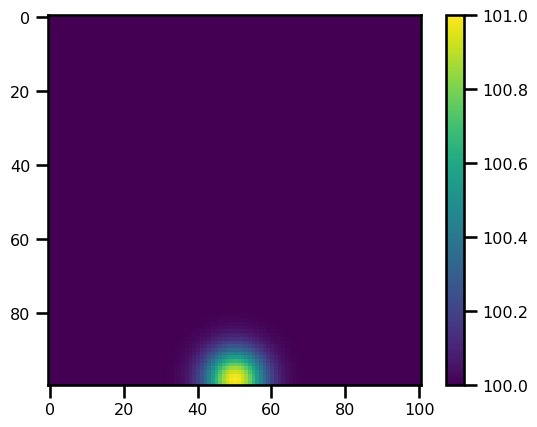

In [106]:
fig, ax = plt.subplots()

pts = ax.imshow(h0, cmap="viridis")
plt.colorbar(pts)
plt.show()

### State

In [267]:
from jaxsw._src.boundaries.functional import neumann_2d


class State(tp.NamedTuple):
    h: Array
    u: Array
    v: Array

    @classmethod
    def init_state(cls, params: StateParams, init_fn: tp.Callable):
        h = init_fn(params)
        v = jnp.zeros_like(h)
        u = jnp.zeros_like(h)

        # h = neumann_2d(h)

        # h = h.at[0,:].set(0.0)
        # h = h.at[-1,:].set(0.0)
        # h = h.at[:,0].set(0.0)
        # h = h.at[:,-1].set(0.0)

        h = h.at[0, :].set(jnp.nan)
        h = h.at[-1, :].set(jnp.nan)
        h = h.at[:, 0].set(jnp.nan)
        h = h.at[:, -1].set(jnp.nan)

        return cls(h=h, u=u, v=v)

In [268]:
state_init = State.init_state(state_params, init_fn=init_h)

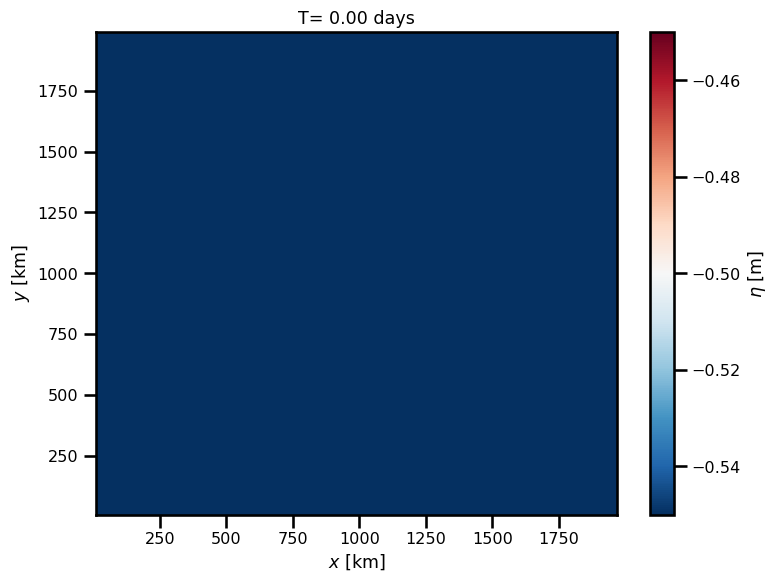

In [269]:
plot_quiver(state_init, state_params, t=0)

## Equation of Motion

Let's rewrite the equation of motion.

$$
\begin{aligned}
\frac{\partial h}{\partial t} &= -  H\left(\frac{\partial u}{\partial x} +
\frac{\partial v}{\partial y}\right) \\
\frac{\partial u}{\partial t} &=  fv -g\frac{\partial h}{\partial x} -ku \\
\frac{\partial v}{\partial t} &= fu -g\frac{\partial h}{\partial y} -kv\\
\end{aligned}
$$

### U-Term

$$
\begin{aligned}
\frac{\partial u}{\partial t} &=  fv -g\frac{\partial h}{\partial x}
\end{aligned}
$$

In [271]:
def u_equations(state, params):
    # parse params
    coriolis_param, gravity, dt = params.coriolis_param, params.gravity, params.dt
    # parse domain
    dx, dy = params.domain.dx[0], params.domain.dx[1]
    # parse state
    u, v, h = state.u, state.v, state.h

    rhs = u.copy()

    # linear coriolis term
    v_avg = 0.25 * (v[1:-1, 1:-1] + v[1:-1, :-2] + v[2:, 1:-1] + v[2:, :-2])

    t1 = coriolis_param * v_avg

    # gravity term
    # du_dx = fdx.difference(h, axis=0, derivative=1, step_size=dx, accuracy=1, method="central")
    du_dx = (h[2:, 1:-1] - h[1:-1, 1:-1]) / dx
    t2 = -gravity * du_dx

    rhs = rhs.at[1:-1, 1:-1].set(t1 + t2)

    return rhs


def enforce_boundaries_u(u: Array) -> Array:
    u = u.at[-2, :].set(0.0)

    return u

In [272]:
u_ = u_equations(state_init, state_params)

u_ = enforce_boundaries_u(u_)
u_

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

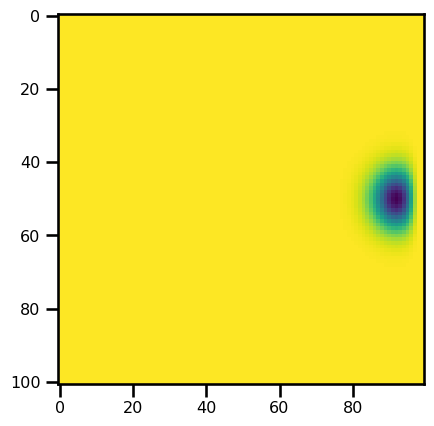

In [273]:
fig, ax = plt.subplots()

ax.imshow(u_.T)

plt.show()

### V-Termz

$$
\begin{aligned}
\frac{\partial v}{\partial t} &= fu -g\frac{\partial h}{\partial y}
\end{aligned}
$$

In [274]:
def v_equations(state, params):
    # parse params
    coriolis_param, gravity, dt = params.coriolis_param, params.gravity, params.dt
    # parse domain
    dx, dy = params.domain.dx[0], params.domain.dx[1]
    # parse state
    u, v, h = state.u, state.v, state.h

    rhs = v.copy()

    # linear coriolis term
    u_avg = 0.25 * (u[1:-1, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[:-2, 2:])

    t1 = coriolis_param * u_avg

    # gravity term
    # dh_dy = fdx.difference(h, axis=1, derivative=1, step_size=dy, accuracy=1, method="central")
    dh_dy = (h[1:-1, 2:] - h[1:-1, 1:-1]) / dy
    t2 = -gravity * dh_dy
    # print(rhs[1:-1,1:-1].shape, t1.shape, t2.shape)
    rhs = rhs.at[1:-1, 1:-1].set(t1 + t2)

    return rhs


def enforce_boundaries_v(v: Array) -> Array:
    v = v.at[:, -2].set(0)

    return v

In [275]:
v_ = v_equations(state_init, state_params)

v_ = enforce_boundaries_v(v_)
v_

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

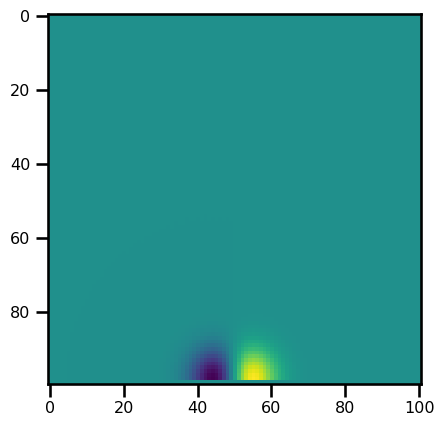

In [276]:
fig, ax = plt.subplots()

ax.imshow(v_)

plt.show()

### H-Term

$$
\begin{aligned}
\frac{\partial h}{\partial t} &=  -H\left(\frac{\partial u}{\partial x} +
\frac{\partial v}{\partial y}\right)
\end{aligned}
$$

In [244]:
from jaxsw._src.boundaries.functional import neumann_2d, dirichlet_face_2d


def h_equations(state, params):
    # parse params
    depth, dt = params.depth, params.dt
    # parse domain
    dx, dy = params.domain.dx[0], params.domain.dx[1]
    # parse state
    u, v, h = state.u, state.v, state.h

    rhs = h.copy()

    # depth term
    # du_dx = fdx.difference(u, axis=0, derivative=1, step_size=dx, accuracy=1, method="central")
    du_dx = (u[1:-1, 1:-1] - u[:-2, 1:-1]) / dx
    # dv_dy = fdx.difference(v, axis=1, derivative=1, step_size=dy, accuracy=1, method="central")
    dv_dy = (v[1:-1, 1:-1] - v[1:-1, :-2]) / dy
    rhs = rhs.at[1:-1, 1:-1].set(-depth * (du_dx + dv_dy))

    return rhs


def enforce_boundaries_h(h: Array) -> Array:
    # v = v.at[:,-2].set(0)
    h = neumann_2d(h)

    return h

In [245]:
h_ = h_equations(state_init, state_params)

h_ = enforce_boundaries_h(h_)
h_

Array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float64)

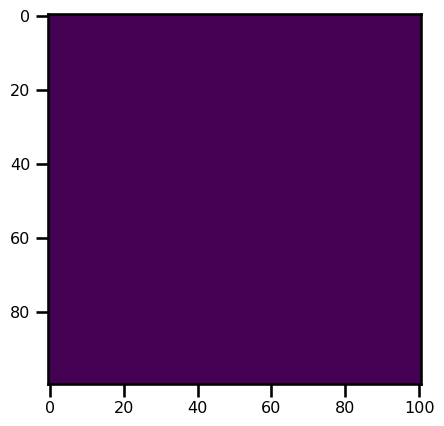

In [246]:
fig, ax = plt.subplots()

ax.imshow(h_)

plt.show()

### Combination

In [247]:
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain


class LinearShallowWater(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """Linear Shallow Water Equations

        Equation:
            ∂u/∂t + u ∂u/∂x + v ∂u/∂y = -ρ ∂p/∂x + ν (∂²u/∂x² + ∂²u/∂y²)
            ∂v/∂t + u ∂v/∂x + v ∂v/∂y = -ρ ∂p/∂y + ν (∂²v/∂x² + ∂²v/∂y²)
            ∂²p/∂x² + ∂²p/∂y² = -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
        """
        # parse params
        params = args
        # do all equations
        u = enforce_boundaries_u(state.u)
        v = enforce_boundaries_v(state.v)

        state = state._replace(u=u, v=v)

        u_rhs = u_equations(state, params)

        v_rhs = v_equations(state, params)

        h_rhs = h_equations(state, params)

        # update state
        state = state._replace(h=h_rhs, u=u_rhs, v=v_rhs)

        return state

In [248]:
# SPATIAL DISCRETIZATION
# initialize state
state_init = State.init_state(state_params, init_fn=init_h)

# right hand side
state_out = LinearShallowWater.equation_of_motion(0, state_init, state_params)

In [249]:
# plot_state_2D(state_out)
# plot_state_3D(state_out)
# plot_vectorfield_2D(state_out)
state_out.u

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

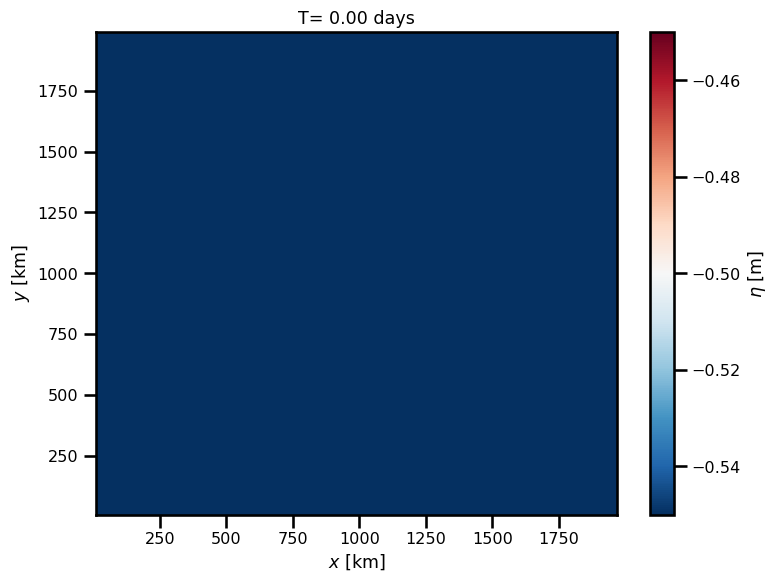

In [250]:
plot_quiver(state_out, state_params, t=1)

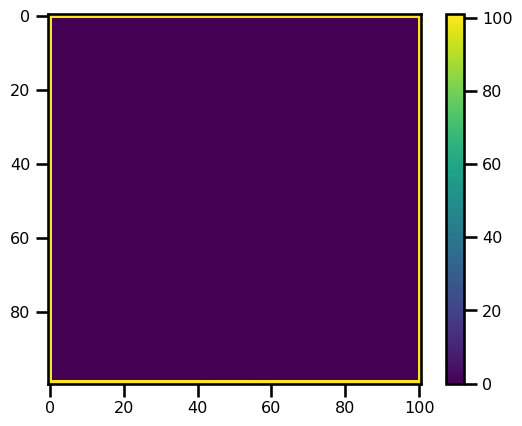

In [251]:
fig, ax = plt.subplots()

pts = ax.imshow(state_out.h)
plt.colorbar(pts)

plt.show()

## Time Stepping

In [252]:
state_params.dt

Array(319.27542841, dtype=float64, weak_type=True)

In [253]:
import pandas as pd
import functools as ft

# TEMPORAL DISCRETIZATION
# initialize temporal domain


dt = state_params.dt
debug = False
num_minutes = 10 * 10
tmin = 0.0
tmax = pd.to_timedelta(num_minutes, unit="minutes").total_seconds()

num_hours_save = 1
dt_save = pd.to_timedelta(num_hours_save, unit="hours").total_seconds()

print(f"Step Size (dt): {int(dt/60)} minutes")
print(f"Tmax: {num_minutes} hours")
print(f"Tmax: {tmax:,} seconds | {int(tmax/60/60)} hours(s)")

Step Size (dt): 5 minutes
Tmax: 100 hours
Tmax: 6,000.0 seconds | 1 hours(s)


### From Scratch

In [261]:
ts = jnp.arange(tmin, tmax + dt, dt)

In [262]:
step = ft.partial(LinearShallowWater.equation_of_motion, args=state_params)

if not debug:
    step = jax.jit(step)

In [263]:
state = State.init_state(state_params, init_fn=init_h)

u, v, h = state.u, state.v, state.h

# state = step(t=0, state=state)

# state = state._replace(v=v)

# state = step(t=0, state=state)

# state = state._replace(h=h)

for iteration in tqdm(ts):
    # SPATIAL DISCRETIZATION

    # right hand side
    state = step(t=iteration, state=state)

    u = u + state_params.dt * state.u
    v = v + state_params.dt * state.v
    h = h + state_params.dt * state.h
    # u = u.at[1:-1,1:-1].set(u[1:-1,1:-1] + state_params.dt * state.u[1:-1,1:-1])
    # v = v.at[1:-1,1:-1].set(v[1:-1,1:-1] + state_params.dt * state.v[1:-1,1:-1])
    # h = h.at[1:-1,1:-1].set(h[1:-1,1:-1] + state_params.dt * state.h[1:-1,1:-1])

    state = state._replace(u=u, v=v, h=h)

  0%|          | 0/20 [00:00<?, ?it/s]

In [264]:
state.h[1:-1, 1:-1].min(), state.h[1:-1, 1:-1].max()

(Array(99.31529071, dtype=float64), Array(100.48553298, dtype=float64))

In [265]:
state_params.depth

100

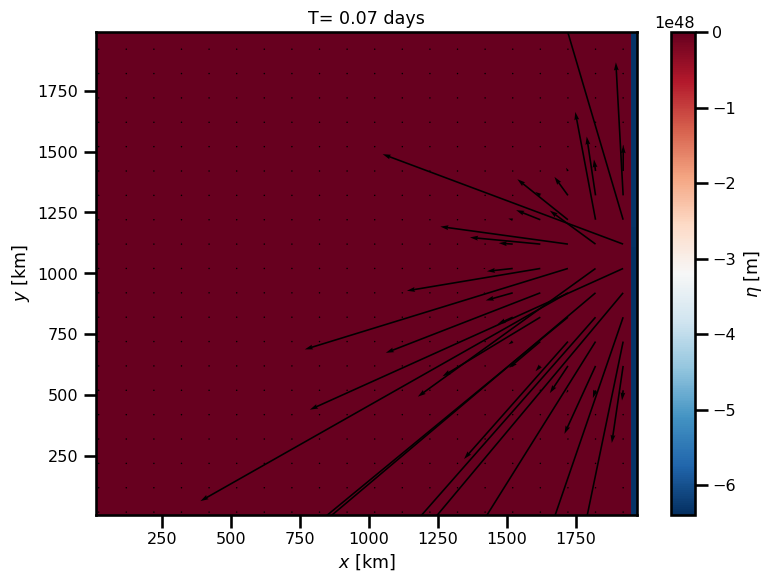

In [266]:
max_quivers = 20
plot_range = 0.5
t = iteration
eta = state.u - state_params.depth

n_x, n_y = state_params.domain.size
XY = state_params.domain.grid
x, y = state_params.domain.coords


quiver_stride = (
    slice(1, -1, n_x // max_quivers),
    slice(1, -1, n_y // max_quivers),
)

fig, ax = plt.subplots(figsize=(8, 6))

pts = ax.pcolormesh(
    XY[1:-1, 1:-1, 0].T / 1e3,
    XY[1:-1, 1:-1, 1].T / 1e3,
    eta[1:-1, 1:-1].T,
    # vmin=-plot_range, vmax=plot_range,
    cmap="RdBu_r",
)
plt.colorbar(pts, label=r"$\eta$ [m]")

if np.any((state.u[quiver_stride] != 0) | (state.v[quiver_stride] != 0)):
    ax.quiver(
        x[quiver_stride[0]] / 1e3,
        y[quiver_stride[1]] / 1e3,
        state.u[quiver_stride].T,
        state.v[quiver_stride].T,
        clip_on=True,
    )

ax.set(
    # aspect="equal",
    xlabel=r"$x$ [km]",
    ylabel=r"$y$ [km]",
    title=f"T={t/86_400:5.2f} days",
)

plt.tight_layout()
plt.show()

In [229]:
def plot_quiver(state, params, t=0, max_quivers=2, plot_range=0.5):
    eta = state.u - params.depth

    n_x, n_y = params.domain.size
    XY = params.domain.grid
    x, y = params.domain.coords

    quiver_stride = (
        slice(1, -1, n_x // max_quivers),
        slice(1, -1, n_y // max_quivers),
    )

    fig, ax = plt.subplots(figsize=(8, 6))

    # print(x.shape, y.shape, eta.shape)

    if np.any((state.u[quiver_stride] != 0) | (state.v[quiver_stride] != 0)):
        ax.quiver(
            x[quiver_stride[0]] / 1e3,
            y[quiver_stride[1]] / 1e3,
            state.u[quiver_stride],
            state.v[quiver_stride],
            clip_on=False,
        )

    pts = ax.pcolormesh(
        XY[1:-1, 1:-1, 0] / 1e3,
        XY[1:-1, 1:-1, 1] / 1e3,
        eta[1:-1, 1:-1],
        vmin=-plot_range,
        vmax=-plot_range,
        cmap="RdBu_r",
    )
    plt.colorbar(pts, label=r"$\eta$ [m]")

    ax.set(
        # aspect="equal",
        xlabel=r"$x$ [km]",
        ylabel=r"$y$ [km]",
        title=f"T={t/86_400:5.2f} days",
    )

    plt.tight_layout()
    plt.show()

In [230]:
plot_quiver(state, state_params, t=1)

ValueError: Image size of 141641x129680 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 2 Axes>

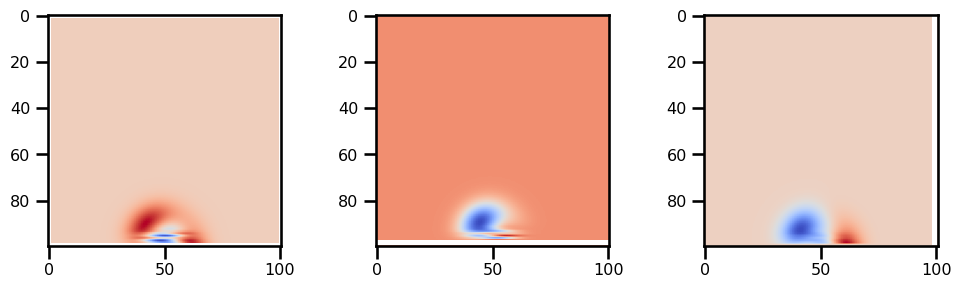

In [231]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

ax[0].imshow(state.h, cmap="coolwarm")
ax[1].imshow(state.u, cmap="coolwarm")
ax[2].imshow(state.v, cmap="coolwarm")

plt.show()

### Grid Setup

In [232]:
x = jnp.arange(n_x) * dx
y = jnp.arange(n_y) * dy

X, Y = jnp.meshgrid(y, x, indexing="ij")

### Initial Conditions


In [26]:
h0 = depth + 1.0 * jnp.exp(
    -((X - x[n_x // 2]) ** 2) / rossby_radius**2
    - (Y - y[n_y - 2]) ** 2 / rossby_radius**2
)
u0 = np.zeros_like(h0)
v0 = np.zeros_like(h0)

In [35]:
u = jnp.empty((n_y, n_x))
v = jnp.empty((n_y, n_x))
h = jnp.empty((n_y, n_x))

u = u.at[...].set(u0)
v = v.at[...].set(v0)
h = h.at[...].set(h0)

### Boundaries

we should not use the boundary values at $h$.

In [38]:
h = h.at[0, :].set(jnp.nan)
h = h.at[-1, :].set(jnp.nan)
h = h.at[:, 0].set(jnp.nan)
h = h.at[:, -1].set(jnp.nan)

## Timings

In [43]:
n_t = 100
ts = jnp.arange(n_t) * dt

In [44]:
from tqdm.autonotebook import tqdm

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_36910/987820437.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


$$
\begin{aligned}
\partial_t u &- f\bar{v} = - g\partial_x h  \\
\partial_t v  &+  f\bar{u} = - g\partial_y h\\
\partial_t h& + H\left(\partial_x u + \partial_y v\right) = 0
\end{aligned}
$$

In [ ]:
def update_u()

In [ ]:
v_avg = 0.25 * 

In [45]:
for t in tqdm(ts):
    continue

  0%|          | 0/100 [00:00<?, ?it/s]

### Plots

In [28]:
plot_range = 0.5
plot_every = 2
max_quivers = 21

In [29]:
def prepare_plot():
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cs = update_plot(0, h0, u0, v0, ax)
    plt.colorbar(cs, label=r"$\eta$ [m]")
    return fig, ax

In [30]:
def update_plot(t, h, u, v, ax):
    eta = h - depth

    quiver_stride = (
        slice(1, -1, n_y // max_quivers),
        slice(1, -1, n_x // max_quivers),
    )

    ax.clear()
    cs = ax.pcolormesh(
        x[1:-1] / 1e3,
        y[1:-1] / 1e3,
        eta[1:-1, 1:-1],
        vmin=-plot_range,
        vmax=plot_range,
        cmap="RdBu_r",
    )

    if np.any((u[quiver_stride] != 0) | (v[quiver_stride] != 0)):
        ax.quiver(
            x[quiver_stride[1]] / 1e3,
            y[quiver_stride[0]] / 1e3,
            u[quiver_stride],
            v[quiver_stride],
            clip_on=False,
        )

    ax.set_aspect("equal")
    ax.set_xlabel(r"$x$ [km]")
    ax.set_ylabel(r"$y$ [km]")
    ax.set_title(
        f"t={t/86_400:5.2f}, R={rossby_radius/1e3:5.1f}, c={phase_speed:5.1f} m/s"
    )
    plt.pause(0.1)
    return cs